## Libraries, constants, imports

In [1]:
import sys, argparse, io, json

# from tqdm import tqdm
from tqdm.autonotebook import tqdm, trange
from typing import List, Tuple, Dict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import gzip

# used to check similarity between reported author names
import Levenshtein

# used to vectorize str of title and authors
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

/tmp/ipykernel_2922393/2096790292.py:4: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [2]:
input_dir = "/home/zxia15/data_zxia15/russian-semantics/work/full_metadata_russian_documents.jsonl.gz"
dump_dir = "/home/zxia15/data_zxia15/russian-semantics/work/filtered_metadata_russian_documents.jsonl.gz"

## Utils Functions

In [3]:
def open_dataframe(df_dir: str, printable: bool = False) -> pd.DataFrame:
    metadata_df = pd.read_json(df_dir, lines=True)
    if printable is True:
        print(metadata_df.head())
    return metadata_df


def dump_dataframe(df_dir: str, df_data: pd.DataFrame) -> None:
    json_str = df_data.to_json(orient="records", lines=True)
    with gzip.open(df_dir, "wt", encoding="utf-8") as f:
        f.write(json_str)
    print(f"successfully dumped into file {df_dir}")

## Filtering

### Filtering 01: Get Rid of all Instances without years

In [1]:
df = open_dataframe(input_dir)
df.head()

NameError: name 'open_dataframe' is not defined

In [5]:
df[df['author'].isna()]

,title,htid,russian text ratio,author,year,form,year_copywright,content_length
0,"I͡Ubileĭnyĭ sbornik Literaturnago fonda, 1859-...",mdp.39015028061110,99.376453,None,NaN,None,1909,1374591
14,Acta horti petropolitani.,mdp.39015045809475,88.362583,None,NaN,None,1873,493080
15,Acta horti petropolitani.,mdp.39015045809616,61.758741,None,NaN,None,1904,25276
16,Acta horti petropolitani.,mdp.39015045809764,79.228687,None,NaN,None,1901,205726
17,Acta horti petropolitani.,mdp.39015045809459,83.537719,None,NaN,None,1902,1161460
...,...,...,...,...,...,...,...,...
89288,Otchet Vserossiĭskogo T͡sentralʹnogo Soveta P...,dul1.ark:/13960/t0jv1hx5g,99.341674,None,NaN,nonfiction,1920,1161631
89291,Finli͡andskai͡a revoli͡ut͡sii͡a :,dul1.ark:/13960/t15n7vt8s,99.537290,None,NaN,nonfiction,1920,369143
89318,Sbornik Vysochaĭshe-utverzhdennykh mni͡enīĭ...,dul1.ark:/13960/t8pd52h2r,99.835683,None,NaN,nonfiction,1869,399787
89325,Materialy dlia kharakteristiki polozheniia rus...,dul1.ark:/13960/t9d63244r,99.401054,None,NaN,nonfiction,1898,434151


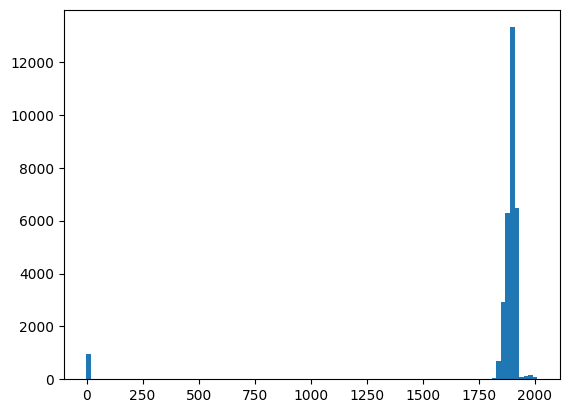

In [10]:
larger_than_1e6_works = df[df['content_length'] >= 1e6]
plt.hist(larger_than_1e6_works['year_copywright'], bins=100)
plt.show()

In [23]:
filtered_01_df = df[df["year_copywright"] != -2]
len(df), len(filtered_01_df)

(89353, 89267)

In [27]:
filtered_01_df[filtered_01_df['year_copywright'] == 0]

,title,htid,russian text ratio,author,year,form,year_copywright,content_length
19018,Nauchnai͡a di͡ei͡atelʹnostʹ professora A.I. Ki...,uc1.$b66528,98.654828,"Lazurskiĭ, V. F.",NaN,nonfiction,0,25889
52108,Pouchen&#xbf;i&#xbf;a v ograzhden&#xbf;e pravo...,inu.30000118943509,99.646603,"Dan&#xbf;kevych, Volodymyr.",NaN,nonfiction,0,168053
80702,"Katalog notnykh rukopiseĭ, pisem i poertretov...",chi.25917806,91.154222,None,NaN,nonfiction,0,181839
81392,Agrarnyĭ vopros v t︠s︡ifrakh i faktakh di︠e︡s...,uiug.30112057051184,99.805374,"Mozzhukhin, I. V.",NaN,nonfiction,0,114356
82400,Sobranīe sochinenīĭ.,nnc1.cu11720069,99.298153,"Sergeev-T͡Senskiĭ, Sergeĭ Nikolaevich,",1958.0,nonfiction,0,989944


In [39]:
filtered_01_df[filtered_01_df['year_copywright'] == 9106]

,title,htid,russian text ratio,author,year,form,year_copywright,content_length
36341,Nado li idti v Gosudarstvennui︠u︡ dumu?,uc1.$b580412,99.583004,"Mi︠a︡kotin, Venedikt Aleksandrovich,",1937.0,nonfiction,9106,65434


In [40]:
non_too_recent_df = filtered_01_df[(filtered_01_df['year_copywright'] != -1) & (filtered_01_df['year_copywright'] != 0) & (filtered_01_df['year_copywright'] != 9106)]
unique_vals = non_too_recent_df['year_copywright'].unique().tolist()
min(unique_vals), max(unique_vals)

(961, 2012)

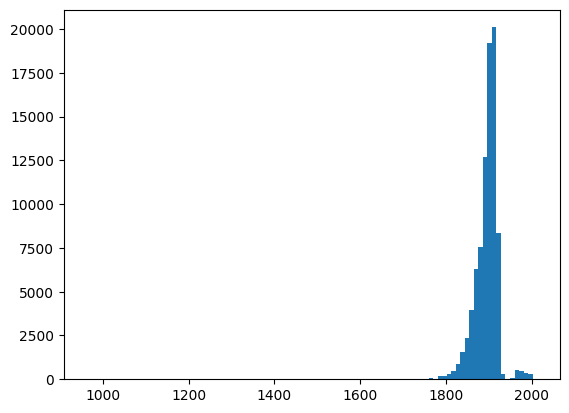

In [43]:
plt.hist(non_too_recent_df['year_copywright'], bins=100, range=(min(unique_vals), max(unique_vals)))
plt.show()

In [46]:
non_too_recent_df[non_too_recent_df['content_length'] == 0]

,title,htid,russian text ratio,author,year,form,year_copywright,content_length
608,Sbornik.,mdp.39015028727884,0.0,None,NaN,None,1916,0
831,Trudy.,mdp.39015085465360,0.0,None,NaN,None,1875,0
1132,Publikatsioonid.,chi.73247644,0.0,None,NaN,None,1866,0
1133,Publikatsioonid.,chi.82273323,0.0,None,NaN,None,1863,0
1135,Publikatsioonid.,chi.82273436,0.0,None,NaN,None,1990,0
...,...,...,...,...,...,...,...,...
89191,Cité antique.,ien.35556026861856,0.0,"Fustel de Coulanges,",1895.0,nonfiction,1903,0
89192,Li︠e︡to;,ien.35556008507162,0.0,"Chisti︠a︡kov, M.",NaN,nonfiction,1901,0
89194,Odin iz mnogikh i drugīe razskazy.,ien.35556008560021,0.0,"Lukashevich, Klavdii︠a︡,",1937.0,nonfiction,1910,0
89196,Morskīe razskazy.,ien.35556008494551,0.0,"Belokha, M. N.",NaN,nonfiction,1915,0


In [61]:
non_too_recent_df[(non_too_recent_df['content_length'] != 0) & (non_too_recent_df['content_length'] < 1e3)]

,title,htid,russian text ratio,author,year,form,year_copywright,content_length
828,Trudy.,mdp.39015080148615,100.000000,None,NaN,None,1894,224
1152,Publikatsioonid.,uc1.32106020706831,90.654206,None,NaN,None,1875,194
1154,Publikatsioonid.,uc1.32106020706856,89.325843,None,NaN,None,1910,159
1310,Annales de l'Observatoire astronomique de Moscow.,nnc1.cu05881846,99.586777,None,NaN,None,1876,241
1313,Annales de l'Observatoire astronomique de Moscow.,mdp.39015035839938,99.722992,None,NaN,None,1876,360
...,...,...,...,...,...,...,...,...
88037,Azbuka v kartinakh /,gri.ark:/13960/t4fn73d8m,97.560976,"Benois, Alexandre,",1960.0,nonfiction,1904,160
88669,Invalid,nc01.ark:/13960/t8nc97j05,98.566308,None,NaN,None,1922,275
88807,Oforty V.E. Makovskago =,gri.ark:/13960/t8vb5v534,99.485420,"Makovskiĭ, Vladimir Egorovich,",1920.0,nonfiction,1887,580
88994,Sto chetyre risunka k poėmi︠e︡ N.V. Gogoli︠a︡...,ien.35556008527145,33.854167,"Agin"", Aleksandr"" Aleksi?e?evich"",",1875.0,nonfiction,1892,65


In [62]:
non_too_recent_df[(non_too_recent_df['content_length'] != 0) & (non_too_recent_df['content_length'] < 1e4)]

,title,htid,russian text ratio,author,year,form,year_copywright,content_length
12,Solovʹinyĭ sad /,mdp.39015037399147,98.824062,"Blok, Aleksandr Aleksandrovich,",1921.0,nonfiction,1918,6555
828,Trudy.,mdp.39015080148615,100.000000,None,NaN,None,1894,224
829,Trudy.,mdp.39015080148755,73.469388,None,NaN,None,1904,2088
1134,Publikatsioonid.,chi.82273378,80.056180,None,NaN,None,1990,1425
1145,Publikatsioonid.,mdp.39015069723487,78.914286,None,NaN,None,1990,1381
...,...,...,...,...,...,...,...,...
88983,"Sobranīe vizantīĭskikh, gruzinskikh i drevn...",gri.ark:/13960/t4gn6pm1w,98.746779,"Gagarin, Grigoriĭ Grigorʹevich,",1893.0,nonfiction,1903,8431
88994,Sto chetyre risunka k poėmi︠e︡ N.V. Gogoli︠a︡...,ien.35556008527145,33.854167,"Agin"", Aleksandr"" Aleksi?e?evich"",",1875.0,nonfiction,1892,65
89180,Polnyĭ russkīĭ pi︠e︡sennik soderzhashchīĭ...,ien.35556008649386,32.748245,None,NaN,nonfiction,1881,653
89221,Niederschriften über die von dem Untersuchung...,dul1.ark:/13960/t6tz4xq52,75.401798,None,NaN,nonfiction,1921,5536


In [47]:
non_zero_content_df = non_too_recent_df[non_too_recent_df['content_length'] != 0]

all_unique_content_length = non_zero_content_df['content_length'].unique().tolist()
min(all_unique_content_length), max(all_unique_content_length)

(7, 24172856)

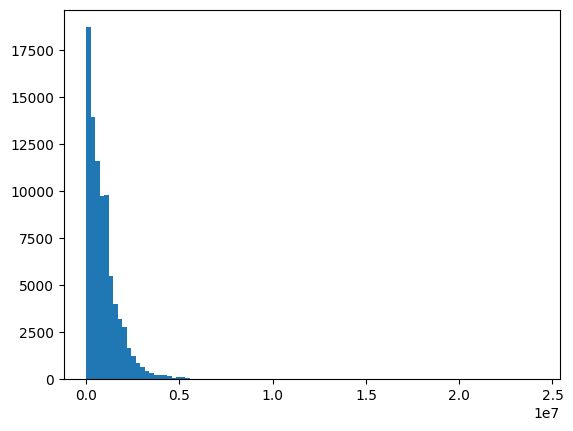

In [59]:
plt.hist(non_zero_content_df['content_length'], bins=100)
plt.show()

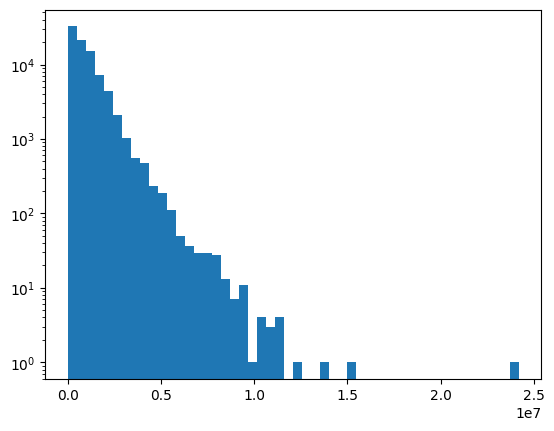

In [55]:
plt.hist(non_zero_content_df['content_length'], bins=50, log=True)
plt.show()

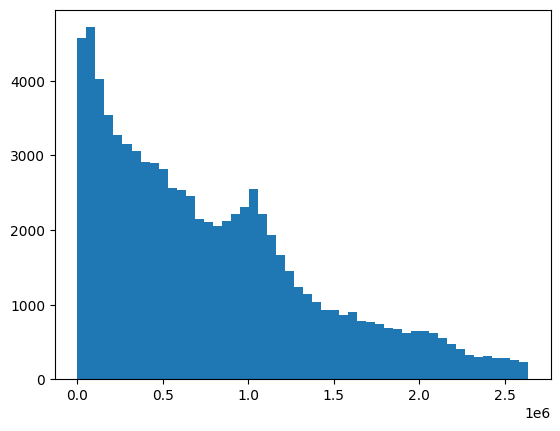

In [58]:
# try plotting graph again without extreme values
Q1 = non_zero_content_df['content_length'].quantile(0.25)
Q3 = non_zero_content_df['content_length'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

IQR_content_df = non_zero_content_df[(non_zero_content_df['content_length'] <= upper_bound) & (non_zero_content_df['content_length'] >= lower_bound)]

plt.hist(IQR_content_df['content_length'], bins=50)
plt.show()

### Filtering 02: Get Rid of all repeated instances

In [6]:
# here we look at all the work 
title_counts = filtered_01_df["title"].value_counts()
non_unique_titles = title_counts[title_counts > 1].index

print(
    f"there are a total of {len(non_unique_titles)} redundant titles and {len(title_counts) - len(non_unique_titles)} unique titles"
    )

there are a total of 7332 redundant titles and 30606 unique titles


In [7]:
# for each title, we deploy the scheme of
#   1. find all authorships across the title
#   2. identify author names that are essentially the same but are only written differently
#   3. group each work by 1) title 2) authorship 3) year

In [8]:
# find unique authorship per title 
#       --> perhaps a better way would be grouping both title and 
#           authorship and then calculate similarities


def filtering_item(instance : pd.Series) -> str:
    title_name : str = '' if (pd.isna(instance['title']) or instance['title'] is None) else str(instance['title'])
    author_name : str = '' if (pd.isna(instance['author']) or instance['author'] is None) else 'by ' + str(instance['author'])
    return title_name + ' ' + author_name

filtered_01_df['title_plus_author'] = filtered_01_df.apply(lambda x : filtering_item(x), axis=1)

/tmp/ipykernel_2388125/841682893.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_01_df['title_plus_author'] = filtered_01_df.apply(lambda x : filtering_item(x), axis=1)


In [9]:
len(filtered_01_df['title_plus_author'].unique().tolist()), filtered_01_df['title_plus_author'].unique().tolist()[:20]

(39684,
 ['I͡Ubileĭnyĭ sbornik Literaturnago fonda, 1859-1909. ',
  'Gogolʹ; tvorchestvo, zhiznʹ i religii͡a. by Merezhkovsky, Dmitry Sergeyevich,',
  'Poėty i poėtessy / by Aĭkhenvalʹd, I︠U︡. I.',
  'Robert Maĭer / by Zami͡atin, Evgeniĭ Ivanovich,',
  'Ofeĭra : putevye zametki by Bely, Andrey,',
  'Uchebnik russkoĭ paleografii / by Shchepkin, V. N.',
  'Współczesne obrazy ideowe wśród Żydów. by Walecki, Henryk,',
  'Solovʹinyĭ sad / by Blok, Aleksandr Aleksandrovich,',
  'Literatura "Slova o polku Igorevi͡e" za posli͡ednee dvadt͡satili͡etie, 1894-1913 g. : by Gudziĭ, N. K.',
  'Acta horti petropolitani. ',
  'Vi͡estnik Narodnoĭ voli. ',
  'Trudy Gosudarstvennogo astronomicheskogo instituta im. P.K. Shternberga. ',
  'Trud v Rossii; ',
  'Revue byzantine. ',
  'Ezhegodnik Narodnogo komissariata po inostrannym delam ... ',
  'Zashchita rasteniĭ ot vrediteleĭ. ',
  'Slaveno-serbskiĭ magazin; ',
  'Byloe. ',
  'Godovoĭ obzor mineralńykh resursov SSSR. ',
  'Russkoe bogatstvo. '])

In [10]:
# use a cosine-similarity matrix to avoid redundancy 
unique_title_plus_author_lists = filtered_01_df['title_plus_author'].unique().tolist()
# similarity_scores_dict : Dict[Tuple[str], float] = {}
# list_correspondence : Dict[str, str] = {}

# for i in tqdm(range(len(unique_title_plus_author_lists))):
#     for j in range(i+1, len(unique_title_plus_author_lists)):
#         item_i : str = unique_title_plus_author_lists[i]
#         item_j : str = unique_title_plus_author_lists[j]
#         similarity_ratio = Levenshtein.ratio(item_i, item_j)
#         similarity_scores_dict[tuple((item_i, item_j))] = similarity_ratio

In [15]:
# use transformer score to vectorize all inputs
model = SentenceTransformer('all-MiniLM-L6-v2')
# Generate embeddings
embeddings = model.encode(unique_title_plus_author_lists, show_progress_bar=True)
np.save('embeddings.npy', embeddings)

Batches:  75%|███████▍  | 925/1241 [9:30:09<3:14:46, 36.98s/it] 


KeyboardInterrupt: 

In [14]:
embeddings = np.load('embeddings.npy')
# Check the shape of the loaded embeddings
embeddings.shape, embeddings

((5, 384),
 array([[-0.00024492,  0.14287324, -0.06977269, ...,  0.02423635,
         -0.02976619, -0.01622874],
        [ 0.02003549,  0.04475284, -0.02335882, ...,  0.10385394,
          0.02467163, -0.05926324],
        [-0.02619782, -0.02949052,  0.04945555, ...,  0.03269483,
          0.05776539, -0.1049362 ],
        [-0.13754122,  0.07935512, -0.08846173, ...,  0.03188613,
         -0.06240201,  0.0209161 ],
        [-0.06804045,  0.09124203, -0.06672686, ...,  0.10466201,
         -0.02386034,  0.03594956]], dtype=float32))

In [19]:
len(embeddings)

NameError: name 'embeddings' is not defined

In [21]:
sorted(similarity_scores_dict.items(), key=lambda item: item[1], reverse=True)

KeyboardInterrupt: 